# Clasificación en MNIST

El dataset MNIST ([link](http://yann.lecun.com/exdb/mnist/)) es un **estándar** para evauar modelos de clasificación. 

Está compuesto por imagenes grises de 28x28 pixeles donde cada imagen posee un digito manuscrito (del 0 al 9) centrado en la misma.

![img](https://tensorflow.rstudio.com/tensorflow/articles/images/MNIST.png)

Este dataset es famoso debido a su gran cantidad de *samples* y a la capacidad de tener buena *performance* con modelos relativamente simples. Es muy usual que MNIST aparezca como dataset de prueba en tutoriales y/o cursos de Machine Learning y Deep Learning.

Hoy en dia es un problema más que resuelto. Existen modelos que ya han conseguido un error < 0.2% en el set de *test*.

Este notebook va a desarrollar una implementacion (en Tensorflow) de una red neuronal de capas totalmente conectadas para resolver el problema (tambien conocidas como *"Fully Connected Networks"* o *"Dense Networks"*). Cada paso va a estar detallado y explicado.

## Importando librerías

El siguiente comando importa las librerias requeridas por el resto del programa. Detallamos las mas importantes:

* **numpy**: para el manejo en CPU de los tensores (vectores multidimensionales)
* **matplotlib**: para graficar en el notebook
* **tensorflow**: para construir y entrenar la red neuronal
* **utils**: modulo propio presente en `utils.py` con funciones auxiliares

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import utils

%matplotlib inline

C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

## Cargando el dataset

A continuación, vamos a cargar el dataset. Para eso, usamos una funcion auxiliar del archivo `utils.py` que se va a encargar de realizar esto.

Esta funcion retorna un 4-upla donde cada elemento es un *numpy array* y además:

* *pics_train*: contiene las imagenes de *training*
* *labels_train*: contiene los labels (el valor real, tambien llamado *ground truth*) de cada una de las iamgenes de *training*
* *pics_test*: contiene las imagenes de *testing*. Estas imagenes solo se van a utilizar al final para medir performance, pero **no para entrenar**.
* *labels_test*: contiene los labels de cada una de las imagenes de *testing*

Estos objetos van a ser nuestros **datos** para el aprendizaje supervisado. En los objetos *"pics"* tenemos nuestros *inputs* y en los objetos *"labels"* tenemos nuestros *outputs*.

La siguiente celda va a descargar de internet el dataset (la primera vez que es ejecutada), asi que es posible que tarde un tiempo.

In [2]:
pics_train, labels_train, pics_test, labels_test = utils.load_mnist()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz

Veamos las dimensiones de cada uno de los *numpy arrays*:

In [3]:
print("Training data:")
print(pics_train.shape)
print(labels_train.shape)
print()
print("Test data:")
print(pics_test.shape)
print(labels_test.shape)

Training data:
(55000, 28, 28, 1)
(55000, 10)

Test data:
(10000, 28, 28, 1)
(10000, 10)


Hay 55000 imagenes de *training* donde cada una es un tensor de 28x28x1 (que representa el valor del gris, en la ultima dimensión, de cada pixel en la imagen). Nota: si bien podría ser 28x28 (es decir, sin el "x1" del final), se acostumbra en la práctica a dejar siempre el formato NWHC (Number - Width - Height - Channels).

A la vez, hay 55000 vectores de 10 que son los *labels* del *training*. El formato del label sigue el patrón *"One-hot encoding"*, en el cual cada valor de verdad se representa como una distribucion de probabilidades por todas las posibles clases. Por ejemplo, para representar el *label* '3', el vector seria [0 0 0 1 0 0 0 0 0 0 0] (osea, todos las clases en 0, menos la correspondiente, en 1). De nuevo, este formato es el estandar para representar los *labels* en un problema de clasificación.

## Graficando algunas imagenes de ejemplo

Usando una de las funciones auxiliares de `utils.py`, podemos observar algunas imagenes acompañadas de su correspondiente *label*, es decir, de su valor de verdad (o *ground truth*).

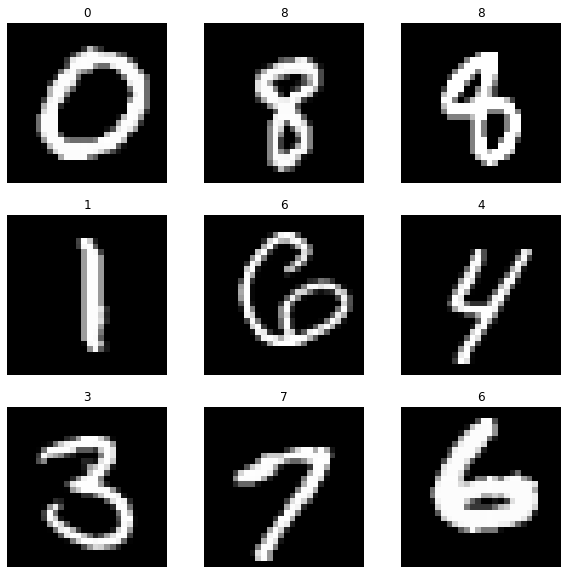

In [4]:
utils.show_random_mnist(pics_train, labels_train)

### Como se representa el valor del pixel en las imagenes?

Como vimos antes, son imagenes en escala de grises (esto significa que tienen un solo canal). Ahora bien, veamos si los valores estan representados entre [0, 255] o entre [0, 1].

In [5]:
print(np.unique(pics_train[0]))

[0.         0.01568628 0.01960784 0.0509804  0.07058824 0.08235294
 0.09019608 0.09803922 0.12156864 0.13333334 0.14509805 0.14901961
 0.16078432 0.18823531 0.20000002 0.22352943 0.2392157  0.24313727
 0.26666668 0.27058825 0.29411766 0.3019608  0.32156864 0.32941177
 0.3372549  0.34901962 0.3529412  0.37647063 0.3803922  0.4156863
 0.4431373  0.45098042 0.45882356 0.46274513 0.4666667  0.48627454
 0.5019608  0.5411765  0.54509807 0.54901963 0.5568628  0.6156863
 0.6509804  0.65882355 0.6627451  0.6901961  0.73333335 0.7411765
 0.74509805 0.7803922  0.7843138  0.8078432  0.81568635 0.8235295
 0.8352942  0.8431373  0.8588236  0.86274517 0.8705883  0.8745099
 0.8862746  0.89019614 0.8941177  0.9058824  0.9176471  0.9215687
 0.9333334  0.93725497 0.94117653 0.9450981  0.9490197  0.95294124
 0.9607844  0.96470594 0.9725491  0.9803922  0.9843138  0.9921569
 0.9960785 ]


Esto quiere decir que los valores están normalizados! Es decir, valores entre 0 y 1. Esto es muy usual en Machine Learning, pues evita problemas numéricos y puede ayudar a la convergencia en la búsqueda de la solución.

## Definiendo el modelo

Generemos algunas variables importantes que nos van a servir luego.

In [6]:
N, H, W, _ = pics_train.shape
F = H * W
NUM_CLASSES = 10

### 1) La Arquitectura

La arquitectura, como se dijo antes, va a ser una red de capas densas unicamente (o *fully-connected*):

![img](https://chsasank.github.io/assets/images/crash_course/mnist_net.png)

La entrada de la red (el *input*) va a ser un vector aplanado de tamaño 28x28. Corresponde a aplanar los valores de cada pixel en un unico vector de 1 dimension. El *output* de la red van a ser 10 valores correspondientes a los *scores* de cada clase.

El flujo sería el siguiente:

1. Tomamos una imagen de 28x28.
2. Se aplana en un vector de una dimension.
3. Se introduce en la red y fluye hacia la capa de salida.
4. La capa de salida va a ser un vector de 10 elementos, donde cada uno representa un *score* de que esa imagen pertenezca a esa clase. Cuanto mayor sea el *score*, buscamos que sea más probable que la imagen pertenezca a esa clase (es decir, que sea ESE digito). Cuando la red esté entrenada, la clase (o el dígito) correcto va a ser aquel que tengo mayor *score*.

No vamos a entrar en profundidad en los detalles de implementacion de Tensorflow. Para aquello, puede recurrir a los tutoriales oficiales [aqui](https://www.tensorflow.org/tutorials/), muy simples de seguir y entender.

In [7]:
def load_architecture():
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, shape=[None, H, W, 1], name="x")
    y = tf.placeholder(tf.uint8, shape=[None, NUM_CLASSES], name="y")
    
    init = tf.contrib.layers.xavier_initializer()
    
    out = tf.contrib.layers.flatten(x)

    out = tf.layers.dense(out, units=256, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dense(out, units=256, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dense(out, units=256, activation=tf.nn.relu, kernel_initializer=init)
    
    out = tf.layers.dense(out, units=NUM_CLASSES, kernel_initializer=init, name="out")
    
    return x, y, out

### 2) La función de costo (*loss*)

La funcion de costo para este problema va a ser la entropía cruzada aplicada a la funcion softmax sobre la capa de salida. Expliquemos un poco esto:

En primer lugar, se computa la funcion softmax sobre la capa de salida (que son los *scores* de las clases). Esta funcion tiene la siguiente pinta:

![img](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

Esta funcion mapea los *scores* a una distribucion de probabilidad, intensificando el valor del maximo (por ejemplo, si los scores hubieran sido [1.3, -0.2, 5.2], la funcion daria un vector ~[0.0197, 0.0044, 0.976]. Ahora, el *output* de la red está en terminos de probabilidad, al igual que el *ground truth*! (acuerdense que está en formato *One-hot encoding*).

Gracias a esto, definimos la entropia cruzada, que es una forma de relacionar dos distribuciones de probabilidad:

![img](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

En resumen, cuando la probabilidad de la clase correcta en el *output* sea relativamente baja, la entropia cruzada va a ser altisima. Cuando sea alta, la entropia va a ser baja. Vamos a intentar minimizar la *loss* (que es la entropia cruzada luego del softmax), para buscar este ultimo comportamiento.

In [8]:
def load_loss(y, out):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out, name="mean_loss")
    loss = tf.reduce_mean(loss, name="loss")
    return loss

La *accuracy* mide el porcentaje de eficacia entre los *labels* y el *output* de la red.

In [9]:
def load_accuracy(y, out):
    pred = tf.argmax(out, axis=-1)
    gt = tf.argmax(y, axis=-1)
    
    matches = tf.equal(pred, gt)
    
    return tf.reduce_mean(tf.cast(matches, tf.float32), name="acc")

### 3) La elección del minimizador

Vamos a estar utilizando Gradiente Descendente Estocástico, comúnmente conocido como *Stochastic Gradient Descent* (SGD) con un *learning rate* de 10e-3.

Para más información acerca de los minimizadores, leer el siguiente excelente blog [aqui](http://ruder.io/optimizing-gradient-descent/).

In [10]:
def load_trainer(loss):
    opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    return opt.minimize(loss)

### Funciones complementarias

Las siguientes funciones son complementarias y no revisten de mayor importancia.

In [11]:
def register_scalars(m):
    for k, v in m.items():
        tf.summary.scalar(k, v)

In [12]:
def register_images(m):
    for k, v in m.items():
        tf.summary.image(k, v)

In [13]:
def trainable_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    return total_parameters

### Modelo Final

La siguiente funcion junta todos los pasos anteriores para definir el modelo final. Esta funcion es la encargada de cargar el grafo en Tensorflow para luego correr la optimizacion.

La funcion retorna aquellos nodos del grafo necesarios para ser corridos luego.

In [14]:
def load_model():
    x, y, out = load_architecture()
    loss = load_loss(y, out)
    acc = load_accuracy(y, out)
    upd = load_trainer(loss)
    
    register_scalars({"info_loss": loss, "info_acc": acc})
    register_images({"input": x})

    info = tf.summary.merge_all()
    
    return x, y, out, loss, acc, upd, info

## Entrenando el modelo

Tensorflow requiere:

1. Definir el grafo computacional (lo que hicimos antes)
2. Correr el grafo a traves de una `Session`.

A continuacion, definimos la sesión.

In [15]:
def load_session():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    return sess

Luego, definimos una funcion que encapsula todo el entrenamiento de la red, es decir, la optimizacion de la funcion de *loss* definida previamente.

Esta funcion recibe la sesion, el modelo, la data, la cantidad de epocas, el tamaño del *batch* (para SGD) y los *writers*, que sirven para hacer uso de la herramienta de visualizacion *tensorboard*.

In [16]:
def train(sess, model, pics_train, labels_train, pics_val, labels_val, epochs, batch_size, train_writer, val_writer):
    N, _, _, _ = pics_train.shape
    idxs = np.arange(N)
    
    x, y, out, loss, acc, upd, info = model
        
    i=0

    for ep in tqdm(range(epochs)):
        np.random.shuffle(idxs)
        pics_train = pics_train[idxs]
        labels_train = labels_train[idxs]

        for b in range(0, N, batch_size):
            X_batch = pics_train[b:b+batch_size]
            Y_batch = labels_train[b:b+batch_size]

            if X_batch.shape[0] < BATCH_SIZE:
                break

            graph_info, _ = sess.run([info, upd], feed_dict={x: X_batch, y: Y_batch})
            train_writer.add_summary(graph_info, i)
            
            graph_info, = sess.run([info], feed_dict={x: pics_val, y: labels_val})
            val_writer.add_summary(graph_info, i)
            
            i+=1

Por ultimo, definimos una funcion que nos va a permitir probar el modelo entrenado. Esta funcion simplemente ejecuta la red con las imagenes que se proveen como parametro. Retorna las inferencias (es decir, las clases "ganadoras") para cada imagen.

In [17]:
def predict(imgs, sess, model):
    x, y, out, loss, acc, upd, info = model

    N, H, W, _ = imgs.shape
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        idx = np.random.choice(range(N)) 
        img = imgs[idx].reshape((1, H, W, 1))
        graph_out, = sess.run([out], feed_dict={x: img})
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.squeeze(img), cmap="gray")
        plt.title(np.argmax(np.squeeze(graph_out)))
    plt.show()

### Corriendo el entrenamiento

Usemos las funciones definidas anteriormente y carguemos el modelo, para luego crear una sesión sobre ese modelo.

In [18]:
model = load_model()
sess = load_session()
print("Trainable parameters: {}".format(trainable_parameters()))



Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.








Trainable parameters: 335114


Ahora, corramos el entrenamiento. El siguiente paso va a llevar un tiempo... (dependiendo tambien si estan corriendo en GPU o CPU). Paciencia. 

In [19]:
EPOCHS = 70
BATCH_SIZE = 64
LOGS_DIR = "logs"

t_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "all", "train"), graph=sess.graph)
v_writer = tf.summary.FileWriter(os.path.join(LOGS_DIR, "all", "val"), graph=sess.graph)

train(sess, model, pics_train, labels_train, pics_test, labels_test, EPOCHS, BATCH_SIZE, t_writer, v_writer)

  1%|▏         | 1/70 [01:01<1:10:12, 61.06s/it]


KeyboardInterrupt: 

En la carpeta `logs` van a poder tener informacion util para analizar el proceso de entrenamiento. Para verla, se necesita levantar `tensorboard`. Para esto, ir a la consola y ejecutar:

```
$ tensorboard --logdir ./logs
```

Se les va a abrir un *tab* en el navegador donde van a poder ver los graficos de entrenamiento en funcion de las épocas.

## Realizando inferencias

Llegamos a la parte mejor parte: **usar el modelo**. Veamos algunas predicciones sobre el set de *training*...

In [ ]:
predict(pics_train, sess, model)

Tiene mucho sentido que tenga una *performance* perfecta pues la red esta entrenada para identificar estos ejemplos puntuales. Medir la *performance* en el dataset de *training* no está aceptado como práctica, pues no es un indicador "honesto". 

Corramos la red para los ejemplos que la red no vió antes, es decir, los de *testing*.

In [ ]:
predict(pics_test, sess, model)

## Performance final

Midamos el *accuracy* final de nuestro modelo sobre todo el set de *testing*.

In [ ]:
x, y, out, loss, acc, upd, info = model

N, H, W, _ = pics_test.shape
graph_out, = sess.run([acc], feed_dict={x: pics_test, y: labels_test})
print("Overall accuracy: {0:.2f}%".format(100 * np.squeeze(graph_out)))